In [1]:
try:
    import urllib2 as urllib
except ImportError:
    import urllib as urlb
import os
import sys
import io
from pandas import Series

In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# 1. PUMA : Public Use Microdata Area

## 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"

In [4]:
urlb.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7f8c2f300a90>)

In [5]:
# ove the downloaded data to PUI data
print("PUIDATA", os.getenv("PUIDATA"))

PUIDATA /nfshome/ys3226/PUIdata


In [6]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ys3226/PUIDATA


In [8]:
# unpacking into $PUIDATA
!unzip file.gz -d $PUIDATA

Archive:  file.gz
  inflating: /nfshome/ys3226/PUIDATA/geo_export_636de871-8e98-487e-9145-74d53a689e04.dbf  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_636de871-8e98-487e-9145-74d53a689e04.shp  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_636de871-8e98-487e-9145-74d53a689e04.shx  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_636de871-8e98-487e-9145-74d53a689e04.prj  


In [9]:
#test if the data is there
!ls $PUIDATA

ACS_16_1YR_GCT2801.ST50_metadata.csv
ACS_16_1YR_GCT2801.ST50.txt
ACS_16_1YR_GCT2801.ST50_with_ann.csv
aff_download_readme_ann.txt
busdata.txt
citibike201801.zip
citibike201806.zip
citibike201807.csv
citibike201807.zip
citybike.zip
geo_export_636de871-8e98-487e-9145-74d53a689e04.dbf
geo_export_636de871-8e98-487e-9145-74d53a689e04.prj
geo_export_636de871-8e98-487e-9145-74d53a689e04.shp
geo_export_636de871-8e98-487e-9145-74d53a689e04.shx
geo_export_dae87114-9002-4016-b067-c7b122f00335.dbf
geo_export_dae87114-9002-4016-b067-c7b122f00335.prj
geo_export_dae87114-9002-4016-b067-c7b122f00335.shp
geo_export_dae87114-9002-4016-b067-c7b122f00335.shx
PLUTO_for_WEB


In [96]:
pumashp = gpd.GeoDataFrame.from_file("%s/geo_export_dae87114-9002-4016-b067-c7b122f00335.shp"%os.getenv("PUIDATA"))

In [104]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [12]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2 plot the PUMA NYC regions

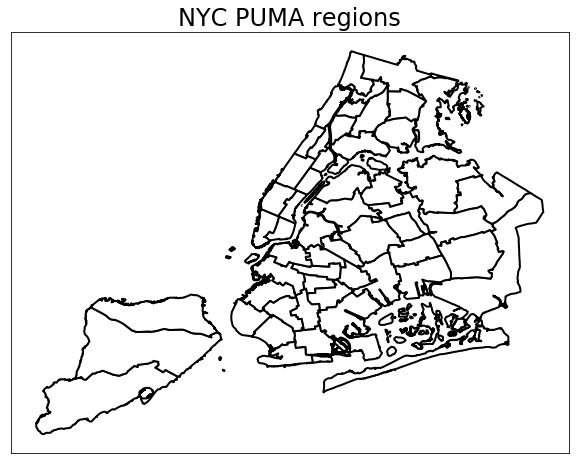

In [147]:
ax = pumashp.plot(column=None, color="white", edgecolor="black", lw=2, figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('NYC PUMA regions', fontsize=24)
plt.show()

   Figure 1: Representation of NYC in black and white by PUMA regions

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

In [14]:
import json
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [16]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

We need two features: **total number of households**, and **number of households with broadband access**

In [17]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [18]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [19]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [208]:
from myCensus import myAPI

In [210]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [150]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [151]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [23]:
puma_merged = pumaBB.merge(pumaPP, left_on='public use microdata area', right_on='public use microdata area', how='inner')

In [24]:
puma_merged.drop(['Unnamed: 4_x', 'NAME_y', 'state_y', 'Unnamed: 4_y'], axis=1, inplace=True)

In [25]:
puma_merged = puma_merged.rename(index=str, columns={"NAME_x": "NAME", "state_x": "state"})
puma_merged.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [48]:
puma_merged['pcBB'] = (puma_merged['B28002_004E'] / puma_merged['B28002_001E']) * 100
puma_merged.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [39]:
puma_merged['public use microdata area'][0]

100

## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [28]:
# unpacking into $PUIDATA
!unzip aff_download.zip -d $PUIDATA

Archive:  aff_download.zip
replace /nfshome/ys3226/PUIDATA/ACS_16_1YR_GCT2801.ST50_with_ann.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [77]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [79]:
bbpc.drop(0, inplace=True)

In [80]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype('int64')

In [69]:
#bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'].str[3:]

In [70]:
#bbpc['gid'].replace('', np.nan, inplace=True)

In [71]:
#bbpc.dropna(subset=['gid'], inplace=True)

In [83]:
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000

In [90]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


In [38]:
#bbpc.drop(['GCT_STUB.target-geo-id2'], axis=1, inplace=True)

### check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [91]:
diff_ = puma_merged.merge(bbpc, right_on='gid', 
                     left_on='public use microdata area', how='inner')[['pcBB', 'HC01']]
diff_['HC01'] = diff_['HC01'].astype(float)
diff_['diff'] = np.abs(diff_['pcBB'] - diff_['HC01'])
diff_.head()
diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [105]:
#choropleth of the percentage of internet axcess
pumashp['puma'] = pumashp['puma'].astype('int64')
pumashp_merged = pumashp.merge(puma_merged, right_on='public use microdata area', left_on='puma', how='inner')
#pumashp.head()

pumashp_merged.head()
#cp.choroplethNYC(...);

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


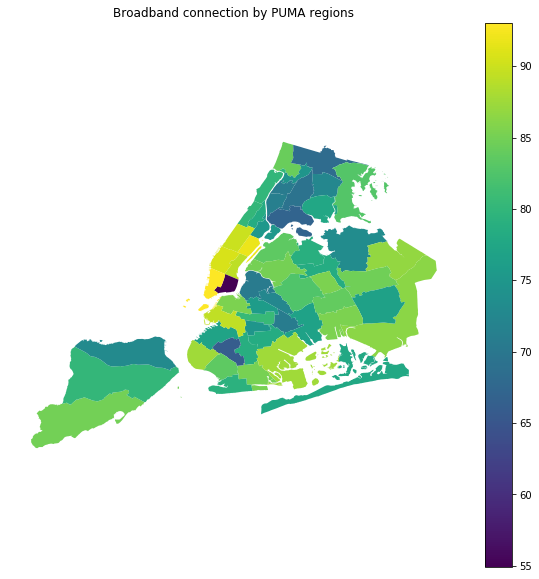

In [178]:
from matplotlib.colors import Normalize
from matplotlib import cm
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = pumashp_merged.plot(column='pcBB',alpha=1,linewidth=0.5,ax=ax, cmap='viridis')
norm = Normalize(vmin=pumashp_merged['pcBB'].min(), vmax=pumashp_merged['pcBB'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='viridis')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap)
ax.set_axis_off()
plt.axis('equal')
plt.title("Broadband connection by PUMA regions")
plt.show()

   Figure 2: Percentages of Broadband Internet connection in NYC by PUMA regions. (Add colorbar)

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [111]:
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv > linkNYC.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75571  100 75571    0     0   491k      0 --:--:-- --:--:-- --:--:--  491k


In [112]:
# move the data
!mv linkNYC.csv $PUIDATA

In [114]:
linkNYC = pd.read_csv("%s/linkNYC.csv"%os.getenv("PUIDATA"))

In [118]:
linkNYC.drop(['Unnamed: 0'], axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [119]:
linkNYC.shape

(1414, 4)

In [187]:
import shapely
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [191]:
from geopandas import GeoDataFrame
linkNYC = GeoDataFrame(linkNYC)

In [193]:
from fiona.crs import from_epsg
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

In [ ]:
# ax = pumashp.plot(column=None, color="white", edgecolor="black", lw=2, figsize=(10,10))

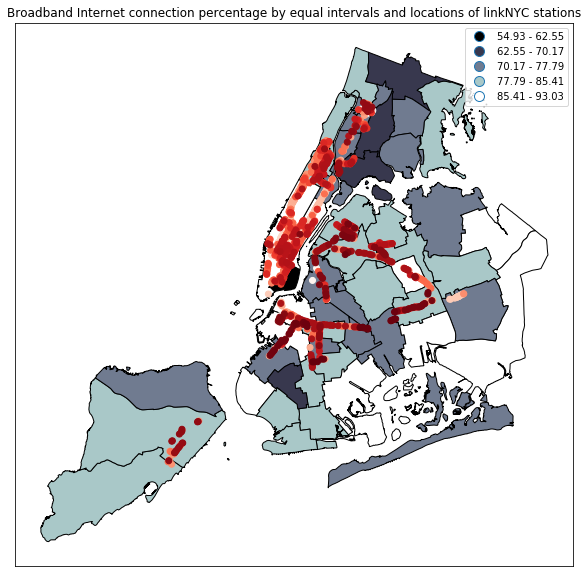

In [206]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp_merged.plot(column='pcBB',cmap='bone',alpha=1,
                  lw=1, ax=ax, scheme="Equal_interval", edgecolor="black", legend=True, k=5)
linkNYC.plot(ax=ax, cmap='Reds')
plt.title("Broadband Internet connection percentage by equal intervals and locations of linkNYC stations")
plt.show()

  Figure 3: Broadband Internet connection percentage by equal intervals and locations of linkNYC stations

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [207]:
#keyword for the total pop of households
keyNtotpop = 'B00001_001E'
aff1y['variables'][keyNtotpop]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [211]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNtotpop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 5.2 find the number of station per 100 people per PUMA